## 1. Maximum A Posteriori estimation

In [79]:
import numpy as np
from scipy.stats import norm

In [80]:
true_value = 2.0
data = norm(true_value, 1.0).rvs(100)

In [81]:
def prior(theta):
    if 0 <= theta <= 4:
        return 1
    else:
        return 0

In [82]:
prior(5)

0

In [83]:
def likelihood(theta, data):
    return np.prod(norm(theta, 1.0).pdf(data))

In [84]:
def posterior(theta, data):
    return likelihood(theta, data) * prior(theta)

In [85]:
values = np.linspace(0,4,1000)
posterior_values = [posterior(theta, data) for theta in values]

In [86]:
max_index = np.argmax(posterior_values)
map_estimate = values[max_index] # find MAP extimate for theta

In [87]:
print(f"MAP estimate for the mean (theta): {map_estimate}")

MAP estimate for the mean (theta): 2.01001001001001


## 2. The NN-based Baysian-like update algorithm for linear regression

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [89]:
torch.manual_seed(123)

In [110]:
X = torch.randn(100, 1)
true_w = torch.tensor([[2.0]])  # true weight
y = torch.sin(X) @ true_w + torch.randn(100, 1) * 0.1  # true data with noise

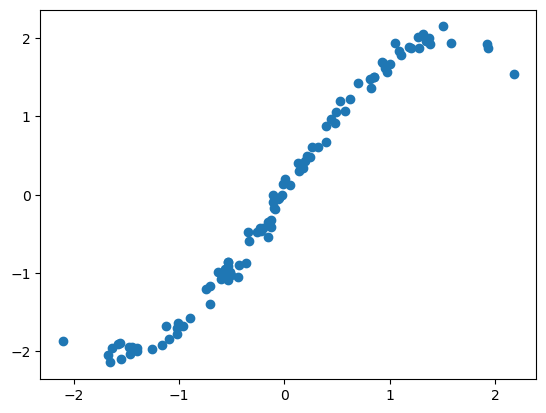

In [111]:
plt.scatter(X, y)

In [114]:
class BNN(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super(BNN, self).__init__()

        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.prior_scale = prior_scale

        self.layer1 = nn.Linear(1, 5)
        self.layer2 = nn.Linear(5, 1)

    def forward(self, x):
        x = x.reshape(-1, self.in_dim)
        x = torch.tanh(self.layer1(x))  # activation function
        mu = self.layer2(x).squeeze()
        sigma = torch.tensor([self.prior_scale], dtype=torch.float32)
        return mu, sigma

    def sample_parameters(self):
        with torch.no_grad():
            for param in self.parameters():
                param.normal_(0, self.prior_scale)

In [115]:
net = BNN()

In [116]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)

### distributive parameter update

In [117]:
for _ in range(1000):
    net.train()
    optimizer.zero_grad()
    mu, sigma = net(X)
    loss = criterion(mu, y)
    loss.backward()
    optimizer.step()

/home/llena/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [118]:
new_X = torch.randn(100, 1)

In [119]:
net.eval()
with torch.no_grad():
    # 여러 번의 샘플링을 통해 예측
    predictions = []
    for _ in range(200):
        net.sample_parameters()  # 파라미터 샘플링
        mu, sigma = net(new_X)
        predictions.append(mu.cpu().numpy())

    predictions = np.array(predictions)

In [120]:
# 평균과 표준편차 계산
mean_predictions = np.mean(predictions, axis=0)
std_predictions = np.std(predictions, axis=0)

In [121]:
single_mean_prediction = np.mean(mean_predictions)
single_std_prediction = np.mean(std_predictions)

In [122]:
single_mean_prediction

2.277914

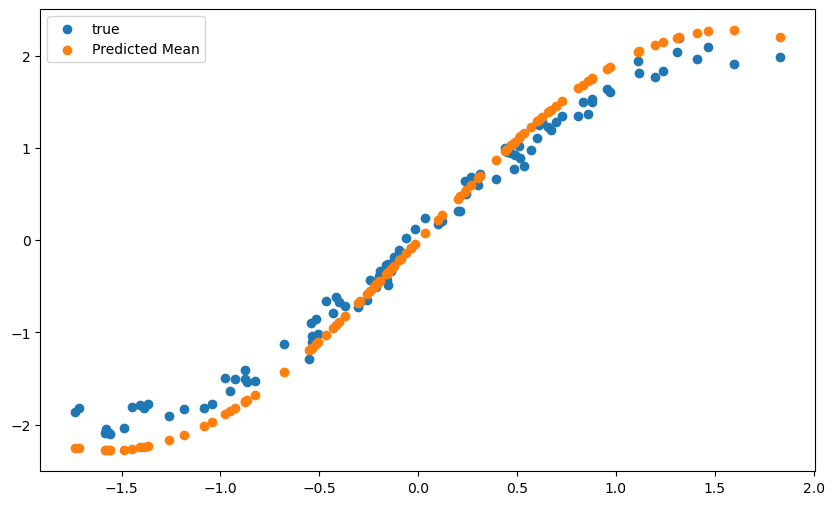

In [127]:
# 테스트 데이터와 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(new_X, np.sin(new_X) * true_w + torch.randn(100, 1) * 0.1 , label='true')
plt.scatter(new_X, np.sin(new_X) * single_mean_prediction, label='Predicted Mean')
# plt.fill_between(new_X, mean_predictions - std_predictions, mean_predictions + std_predictions, alpha=0.5, label='Predicted Std Dev')
plt.legend()
plt.show()

## 3. The NN-based Baysian update algorithm for 3D linear regression

In [23]:
torch.manual_seed(42)
np.random.seed(42)

In [24]:
X = torch.randn(100, 3)
true_w = torch.tensor([2.0, -3.0, 1.0])  # true weights
b_true = torch.tensor([0.5])  # true bias
y = X @ true_w + b_true + torch.randn(100) * 0.5  # add some noise
y = y.unsqueeze(1)  # Reshape y to have the shape [100, 1]

In [25]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(3, 5, bias=False)
        self.linear = torch.nn.Linear(5, 3, bias=False)
        self.linear = torch.nn.Linear(3, 1, bias=False)
        
    def forward(self, x):
        return self.linear(x)

In [26]:
# Initialize the model
model = LinearModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [27]:
# Train the model with initial data
for _ in range(500):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

- prior: $\mathcal{N}(0,I)$
- likelihood : $\mathcal{N}(y|wX,I)$
- posterior : $N(w|m,S)$ with $m = S(X'X + I)^{-1}X'y$ and $S = (X'X + I)^{-1}$

In [28]:
def bayesian_update(model, X, y, prior_var=1.0):
    I = torch.eye(X.shape[1])
    precision_prior = I / prior_var
    precision_likelihood = X.t() @ X

    # Posterior precision (inverse covariance)
    precision_posterior = precision_prior + precision_likelihood
    covariance_posterior = torch.inverse(precision_posterior)

    # Posterior mean
    mean_posterior = covariance_posterior @ X.t() @ y

    # Update model weights with the posterior mean
    model.linear.weight = torch.nn.Parameter(mean_posterior.t())

    return mean_posterior, covariance_posterior

In [29]:
w_posterior_mean, covariance_posterior = bayesian_update(model, X, y)

### Visualization

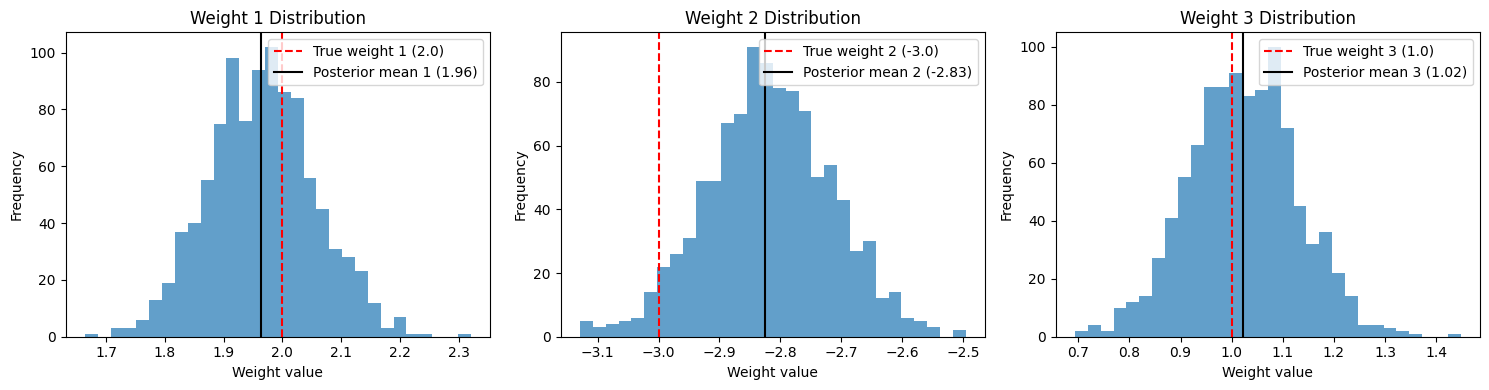

In [30]:
def plot_weight_distribution(w_posterior_mean, covariance_posterior):
    w_posterior_std = torch.sqrt(torch.diag(covariance_posterior)).unsqueeze(1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i in range(3):
        ax = axes[i]
        w_samples = np.random.normal(w_posterior_mean[i].item(), w_posterior_std[i].item(), 1000)
        ax.hist(w_samples, bins=30, alpha=0.7)
        ax.axvline(x=true_w[i].item(), color='r', linestyle='--', label=f"True weight {i+1} ({true_w[i].item()})")
        ax.axvline(x=w_posterior_mean[i].item(), color='k', linestyle='-', label=f"Posterior mean {i+1} ({w_posterior_mean[i].item():.2f})")
        ax.set_title(f'Weight {i+1} Distribution')
        ax.legend()
        ax.set_xlabel('Weight value')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

plot_weight_distribution(w_posterior_mean.squeeze(), covariance_posterior)

## 4. Applying reinforcement learning to Bayesian parameter updates

simple task: find the optimal learning rate that maximizes the accuracy of our updated parameter estimation using Q-learning

- state : discretized representation of the current estimate's error
- action : adjustment of the learning rate 
- reward : the negative loss 

In [31]:
true_parameter = torch.tensor(2.0)

In [32]:
# Bayesian update function for the Gaussian mean

def bayesian_update(current_mean, observation, learning_rate):
    return current_mean + learning_rate * (observation - current_mean)

In [94]:
def get_state(estimate):
    error = torch.abs(estimate - true_parameter)  # 이 값은 continuous 한 에러값을 
    state = min(int(error // 0.5), n_states - 1)  # Discretize the error into states
    return state

In [95]:
def get_reward(estimate):
    return -torch.square(estimate - true_parameter)

In [96]:
# Hyperparameters for the Q-learning

alpha = 0.1  # Learning rate for updating the Q-values
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate for epsilon-greedy policy

In [97]:
n_states = 10  # for example, 10 different levels of improvement in the loss
n_actions = 100  # decrease, keep, or increase the learning rate
learning_rates = torch.linspace(0.1, 0.99, 100)  # Learning rates for updating the parameter estimate within Bayesian rule

In [98]:
# Initialize Q-table with all zeros

Q = torch.zeros((n_states, n_actions), dtype=torch.float)

In [99]:
def choose_action(state, Q, epsilon):
    if torch.rand(1).item() < epsilon:
        return torch.randint(0, n_actions, (1,)).item()
    else:
        return torch.argmax(Q[state]).item()

In [100]:
type(Q)

torch.Tensor

In [101]:
n_episodes = 1000

for episode in range(n_episodes):
    current_estimate = torch.tensor(torch.rand(1).item() * 10)  # Random initial estimate
    for step in range(100):
        state = get_state(current_estimate)
        action = choose_action(state, Q, epsilon)
        learning_rate = learning_rates[action]

        observation = true_parameter + torch.randn(1)

        updated_estimate = bayesian_update(current_estimate, observation, learning_rate)
        reward = get_reward(updated_estimate)
        next_state = get_state(updated_estimate)

        # Q-learning update rule
        Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * torch.max(Q[next_state]))

        current_estimate = updated_estimate

In [102]:
# Extract the optimal policy from the Q-learning

optimal_policy = torch.argmax(Q, axis=1)
optimal_learning_rates = learning_rates[optimal_policy]

In [103]:
print("Optimal learning rates for each state:")
for i, rate in enumerate(optimal_learning_rates):
    print(f"State {i}: Learning rate {rate:.2f}")

Optimal learning rates for each state:
State 0: Learning rate 0.13
State 1: Learning rate 0.13
State 2: Learning rate 0.71
State 3: Learning rate 0.43
State 4: Learning rate 0.16
State 5: Learning rate 0.99
State 6: Learning rate 0.49
State 7: Learning rate 0.66
State 8: Learning rate 0.71
State 9: Learning rate 0.90


tensor(1.8210)
2.0


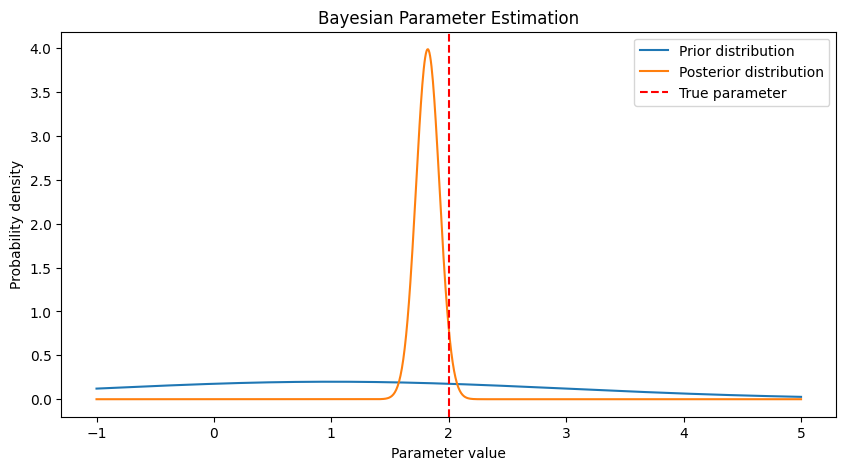

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Assume a normal prior
prior_mean = 1.0
prior_std = 2.0
true_parameter = 2.0

# Assume initial posterior mean and std are equal to the prior's
posterior_means = [prior_mean]
posterior_stds = [prior_std]

min_std = 0.1
n_episodes = 100

# Sample observations and update posterior across episodes
for episode in range(n_episodes):
    current_estimate = torch.tensor(torch.rand(1).item() * 10)  # Random initial estimate
    for step in range(100):
        state = get_state(current_estimate)
        action = choose_action(state, Q, epsilon)
        learning_rate = learning_rates[action]

        observation = true_parameter + torch.randn(1)
        updated_estimate = bayesian_update(current_estimate, observation, learning_rate)

        # Assuming the update rule follows the Bayesian update in a Gaussian context,
        # we would update the mean like so, and reduce the variance each time we learn.
        current_mean = posterior_means[-1]
        current_std = posterior_stds[-1]
        new_mean = current_mean + learning_rate * (observation.item() - current_mean)
        new_std = max(min_std, current_std * (1 - learning_rate))  # Simplified update for standard deviation

        posterior_means.append(new_mean)
        posterior_stds.append(new_std)
        current_estimate = updated_estimate

# Calculate the final posterior mean and std from the last updates
posterior_mean = posterior_means[-1]
posterior_std = posterior_stds[-1]

# Plotting
x = np.linspace(-1, 5, 1000)
prior_dist = (np.exp(-(x - prior_mean) ** 2 / (2 * prior_std ** 2)) / (np.sqrt(2 * np.pi) * prior_std))

# Convert posterior_mean and posterior_std to numpy if they are Tensors
posterior_mean_np = posterior_mean if isinstance(posterior_mean, float) else posterior_mean.item()
posterior_std_np = posterior_std if isinstance(posterior_std, float) else posterior_std.item()

# Now calculate the posterior distribution using numpy operations
posterior_dist = (np.exp(-(x - posterior_mean_np) ** 2 / (2 * posterior_std_np ** 2)) / (np.sqrt(2 * np.pi) * posterior_std_np))

print(posterior_mean)
print(true_parameter)

plt.figure(figsize=(10, 5))
plt.plot(x, prior_dist, label='Prior distribution')
plt.plot(x, posterior_dist, label='Posterior distribution')
plt.axvline(true_parameter, color='r', linestyle='--', label='True parameter')
plt.title('Bayesian Parameter Estimation')
plt.xlabel('Parameter value')
plt.ylabel('Probability density')
plt.legend()
plt.show()

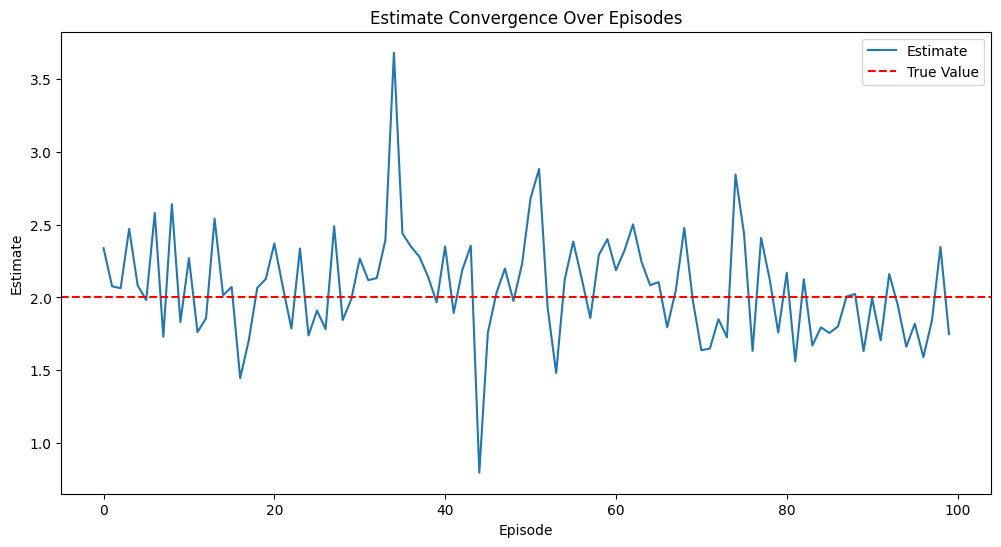

In [105]:
# 파라미터 설정
n_episodes = 100  # 에피소드의 총 수
min_std = 0.1  # 최소 표준 편차 값
true_value = 2.0  # 진짜 값

# 추정값과 표준 편차를 저장할 리스트 초기화
estimate_history = []
std_history = []

# 에피소드를 반복하여 학습 실행
for episode in range(n_episodes):
    current_estimate = torch.tensor([torch.rand(1).item() * 10])  # Random initial estimate
    # 초기 포스터리어 평균과 표준편차 설정
    current_mean = current_estimate
    current_std = torch.tensor([1.0])  # 초기 표준 편차

    for step in range(100):
        # 여기에서 `get_state`, `choose_action` 함수와 `learning_rates`, `Q`, `epsilon` 변수가 정의되어야 함
        state = get_state(current_estimate)
        action = choose_action(state, Q, epsilon)
        learning_rate = learning_rates[action]

        observation = true_parameter + torch.randn(1)
        updated_estimate = bayesian_update(current_estimate, observation, learning_rate)
        # Bayesian 업데이트 규칙을 따름
        new_mean = current_mean + learning_rate * (observation - current_mean)
        # 표준 편차 업데이트 (최소 표준 편차 적용)
        new_std = torch.max(torch.tensor([min_std]), current_std * (1 - learning_rate))

        # 포스터리어 평균과 표준편차 갱신
        current_mean = new_mean
        current_std = new_std
        current_estimate = updated_estimate

    estimate_history.append(current_mean.item())
    std_history.append(current_std.item())

# 추정값과 표준 편차의 시각화
plt.figure(figsize=(12, 6))

# 추정값 변화 그래프
plt.plot(estimate_history, label='Estimate')
plt.axhline(y=true_value, color='r', linestyle='--', label='True Value')
plt.xlabel('Episode')
plt.ylabel('Estimate')
plt.title('Estimate Convergence Over Episodes')
plt.legend()
